<a href="https://colab.research.google.com/github/Datbwoyyy/unsloth/blob/main/REMOVE_BREAKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unsloth --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/5

In [ ]:
!apt-get install -y cuda-toolkit-12-1
!export PATH=/usr/local/cuda-12.1/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-12.1/lib64${LD_LIBRARY_PATH:+:${LD_LIBRARY_PATH}}


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cuda-cccl-12-1 cuda-command-line-tools-12-1 cuda-compiler-12-1 cuda-cudart-12-1
  cuda-cudart-dev-12-1 cuda-cuobjdump-12-1 cuda-cupti-12-1 cuda-cupti-dev-12-1 cuda-cuxxfilt-12-1
  cuda-documentation-12-1 cuda-driver-dev-12-1 cuda-gdb-12-1 cuda-libraries-12-1
  cuda-libraries-dev-12-1 cuda-nsight-12-1 cuda-nsight-compute-12-1 cuda-nsight-systems-12-1
  cuda-nvcc-12-1 cuda-nvdisasm-12-1 cuda-nvml-dev-12-1 cuda-nvprof-12-1 cuda-nvprune-12-1
  cuda-nvrtc-12-1 cuda-nvrtc-dev-12-1 cuda-nvtx-12-1 cuda-nvvp-12-1 cuda-opencl-12-1
  cuda-opencl-dev-12-1 cuda-profiler-api-12-1 cuda-sanitizer-12-1 cuda-toolkit-12-1-config-common
  cuda-tools-12-1 cuda-visual-tools-12-1 default-jre default-jre-headless fonts-dejavu-core
  fonts-dejavu-extra gds-tools-12-1 libatk-wrapper-java libatk-wrapper-java-jni libcublas-12-1
  libcublas-dev-12-1 libcufft-12-1 l

In [ ]:
!pip install bitsandbytes


In [ ]:
!pip install -U bitsandbytes
# Restart the runtime after installing to ensure the updated library is loaded
# If you're using a Jupyter Notebook, you can restart the kernel.
# In Colab, you can restart the runtime from the 'Runtime' menu.

import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig
# ... (rest of the code remains the same)

torch_compile_options = {
    "epilogue_fusion"   : True,
    "max_autotune"      : True,
    "shape_padding"     : True,
    "trace.enabled"     : True,
    "triton.cudagraphs" : False,
}

# Environment settings
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,roundup_power2_divisions:[32:256,64:128,256:64,>:32]"

torch.set_default_dtype(torch.float16)
model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"

# Load quantization config
dtype = torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit              = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type       = "nf4",
    bnb_4bit_compute_dtype    = dtype,
)
# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map = "auto",
    attn_implementation = "sdpa",
    quantization_config = bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"

# LoRA Configuration
lora_config = LoraConfig(
    r = 32,
    lora_alpha = 64,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout = 0,
    bias = "none",
    task_type = TaskType.CAUSAL_LM,
)

# Get LoRA and setup model
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name:
            param.requires_grad_(True)
        else:
            param.requires_grad_(False)

# Enable input gradients
model.enable_input_require_grads()

# Detect graph breaks
def detect_graph_breaks():
    with torch.no_grad():
        x = torch.randint(0, tokenizer.vocab_size, (1, 32), device=model.device, dtype=torch.long)  # Use torch.randint and dtype=torch.long
        compiled_fn = torch.compile(model.forward, fullgraph=False, dynamic=True, options=torch_compile_options)
        compiled_fn(input_ids=x) # Pass x as input_ids

detect_graph_breaks()

# Compile attention and MLP modules
import transformers.models.llama.modeling_llama as llama_mod
@torch.compile(fullgraph=False, dynamic=True, options=torch_compile_options)
def compiled_llama_mlp(self, x):
    down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
    return down_proj

llama_mod.LlamaMLP.forward = compiled_llama_mlp

@torch.compile(fullgraph=False, dynamic=True, options=torch_compile_options)
def compiled_llama_attention(self, hidden_states, attention_mask=None):
    return self.self_attn(hidden_states, attention_mask=attention_mask)

llama_mod.LlamaAttention.forward = compiled_llama_attention

# Load dataset
url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files={"train": url}, split="train[:10%]")

print("Model compiled successfully without excessive graph breaks!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.11/dist-packages/transformers/quantizers/auto.py:195: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/_config_module.py:342: UserWarning: Skipping serialization of skipfiles_inline_module_allowlist value {}
  warnings.warn(
W0219 00:07:36.748000 798 torch/_inductor/debug.py:435] [13/0] model__0_inference_0 debug trace: /content/torch_compile_debug/run_2025_02_19_00_07_30_586713-pid_798/torchinductor/model__0_inference_0.0
/usr/local/lib/python3.11/dist-packages/torch/utils/_config_module.py:342: UserWarning: Skipping serialization of skipfiles_inline_module_allowlist value {}
  warnings.warn(
W0219 00:07:37.156000 798 torch/_inductor/utils.py:1137] [14/0] Not enough SMs to use max_autotune_gemm mode
W0219 00:07:39.333000 798 torch/_inductor/debug.py:435] [14/0] model__1_inference_1 debug trace: /content/torch_compile_debug/run_2025_02_19_00_07_30_586713-pid_798/torchinductor/model__1_inference_1.1
/usr/local/lib/python3.11/dist-packages/torch/utils/_config_module.py:342: UserWarning: Skipping serialization of skipfiles_inline_module_a

unified_chip2.jsonl:   0%|          | 0.00/95.6M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Model compiled successfully without excessive graph breaks!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast
import time
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a QLoRA model
class QLoRAModel(nn.Module):
    def __init__(self, input_dim, output_dim, rank):
        super(QLoRAModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

        # LoRA Parameters (Fixed Syntax)
        self.lora_A = nn.Parameter(torch.randn(input_dim, rank) * 0.01)  # [input_dim, rank]
        self.lora_B = nn.Parameter(torch.randn(rank, output_dim) * 0.01)  # [rank, output_dim]

        self.rank = rank

    def forward(self, x):
        base_output = self.linear(x)  # Shape: [batch_size, output_dim]
        lora_update = torch.matmul(x, self.lora_A)  # [batch_size, input_dim] x [input_dim, rank] -> [batch_size, rank]
        lora_update = torch.matmul(lora_update, self.lora_B)  # [batch_size, rank] x [rank, output_dim] -> [batch_size, output_dim]

        return base_output + lora_update  # Shapes now match: [batch_size, output_dim]

# Generate dummy data
def generate_data(num_samples, input_dim):
    x = torch.randn(num_samples, input_dim)
    y = torch.randn(num_samples, 1)
    return x, y

# Training function
def train_model(model, dataloader, optimizer, scaler, num_epochs=10):
    model.train()
    total_time = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0.0

        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Use autocast for mixed precision training
            #with autocast():
            output = model(data)
            loss = nn.functional.mse_loss(output, target)

            # Scale loss and backpropagate
            loss.backward() # Scale the loss and perform backward pass
            #scaler.unscale_(optimizer) # Unscale the gradients before optimizer step
            optimizer.step()
            #scaler.update()

            epoch_loss += loss.item()

            # Log every 10 batches
            if batch_idx % 10 == 0:
                logger.info(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")

        epoch_time = time.time() - start_time
        total_time += epoch_time
        logger.info(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f} seconds, Avg Loss: {epoch_loss / len(dataloader):.4f}")

    logger.info(f"Total training time: {total_time:.2f} seconds")

# Main function
def main():
    # Hyperparameters
    input_dim = 128
    output_dim = 64
    rank = 8
    num_samples = 1000
    batch_size = 32
    num_epochs = 5
    learning_rate = 1e-3

    # Generate data
    x, y = generate_data(num_samples, input_dim)
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model, optimizer, and scaler
    model = QLoRAModel(input_dim, output_dim, rank).to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scaler = GradScaler()

    # Check if torch.compile is available
    if hasattr(torch, 'compile'):
        logger.info("Compiling the model with torch.compile...")
        model = torch.compile(model, mode='max-autotune')

    # Log memory usage before training
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        start_memory = torch.cuda.memory_allocated()
        logger.info(f"Memory allocated before training: {start_memory / 1024 ** 2:.2f} MB")

    # Train the model
    logger.info("Starting training...")
    train_model(model, dataloader, optimizer, scaler, num_epochs)

    # Log memory usage after training
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        end_memory = torch.cuda.memory_allocated()
        logger.info(f"Memory allocated after training: {end_memory / 1024 ** 2:.2f} MB")

if __name__ == "__main__":
    main()

<ipython-input-24-7b2251ee4712>:97: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-24-7b2251ee4712>:58: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(output, target)
<ipython-input-24-7b2251ee4712>:58: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(output, target)
<ipython-input-24-7b2251ee4712>:58: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 64])). This will likely lead to incorrect results due to broadcas

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
import time
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a QLoRA model
class QLoRAModel(nn.Module):
    def __init__(self, input_dim, output_dim, rank):
        super(QLoRAModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

        # LoRA Parameters (Fixed Syntax)
        self.lora_A = nn.Parameter(torch.randn(input_dim, rank) * 0.01)
        self.lora_B = nn.Parameter(torch.randn(rank, output_dim) * 0.01)

        self.rank = rank

    def forward(self, x):
        base_output = self.linear(x)
        lora_update = torch.matmul(x, self.lora_A)
        lora_update = torch.matmul(lora_update, self.lora_B)
        return base_output + lora_update

# Generate dummy data
def generate_data(num_samples, input_dim, output_dim):
    x = torch.randn(num_samples, input_dim)
    y = torch.randn(num_samples, output_dim)  # Ensure correct shape
    return x, y

# Training function
def train_model(model, dataloader, optimizer, num_epochs=10):
    model.train()
    total_time = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0.0

        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Forward pass
            output = model(data)
            loss = nn.functional.mse_loss(output, target)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Log every 10 batches
            if batch_idx % 10 == 0:
                logger.info(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")

        epoch_time = time.time() - start_time
        total_time += epoch_time
        logger.info(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f} seconds, Avg Loss: {epoch_loss / len(dataloader):.4f}")

    logger.info(f"Total training time: {total_time:.2f} seconds")

# Main function
def main():
    # Hyperparameters
    input_dim = 128
    output_dim = 64
    rank = 8
    num_samples = 1000
    batch_size = 32
    num_epochs = 5
    learning_rate = 1e-3

    # Generate data
    x, y = generate_data(num_samples, input_dim, output_dim)
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model and optimizer
    model = QLoRAModel(input_dim, output_dim, rank)

    # ✅ Selective Compilation (Only Compile QLoRA)
    if hasattr(torch, 'compile'):
        logger.info("Compiling the model with torch.compile...")
        model.linear = torch.compile(model.linear, mode='reduce-overhead')  # Compile only the linear layer
        # LoRA parameters are small, avoid unnecessary compilation

    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Log memory usage before training
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        start_memory = torch.cuda.memory_allocated()
        logger.info(f"Memory allocated before training: {start_memory / 1024 ** 2:.2f} MB")

    # Train the model
    logger.info("Starting training...")
    train_model(model, dataloader, optimizer, num_epochs)

    # Log memory usage after training
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        end_memory = torch.cuda.memory_allocated()
        logger.info(f"Memory allocated after training: {end_memory / 1024 ** 2:.2f} MB")

if __name__ == "__main__":
    main()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
import time
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a QLoRA model
class QLoRAModel(nn.Module):
    def __init__(self, input_dim, output_dim, rank):
        super(QLoRAModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

        # LoRA Parameters (Fixed Syntax)
        self.lora_A = nn.Parameter(torch.randn(input_dim, rank) * 0.01)
        self.lora_B = nn.Parameter(torch.randn(rank, output_dim) * 0.01)

        self.rank = rank

    def forward(self, x):
        base_output = self.linear(x)
        lora_update = torch.matmul(x, self.lora_A)
        lora_update = torch.matmul(lora_update, self.lora_B)
        return base_output + lora_update

# Generate dummy data
def generate_data(num_samples, input_dim, output_dim):
    x = torch.randn(num_samples, input_dim)
    y = torch.randn(num_samples, output_dim)  # Ensure correct shape
    return x, y

# Training function
def train_model(model, dataloader, optimizer, num_epochs=10):
    model.train()
    total_time = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0.0

        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Forward pass
            output = model(data)
            loss = nn.functional.mse_loss(output, target)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Log every 10 batches
            if batch_idx % 10 == 0:
                logger.info(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}")

        epoch_time = time.time() - start_time
        total_time += epoch_time
        logger.info(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f} seconds, Avg Loss: {epoch_loss / len(dataloader):.4f}")

    logger.info(f"Total training time: {total_time:.2f} seconds")

# Main function
def main():
    # Hyperparameters
    input_dim = 128
    output_dim = 64
    rank = 8
    num_samples = 1000
    batch_size = 32
    num_epochs = 5
    learning_rate = 1e-3

    # Generate data
    x, y = generate_data(num_samples, input_dim, output_dim)
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model and optimizer
    model = QLoRAModel(input_dim, output_dim, rank)

    # ✅ Compile the entire model if possible
    if hasattr(torch, 'compile'):
        logger.info("Compiling the model with torch.compile...")
        model = torch.compile(model, mode='reduce-overhead')  # Compile the entire model

    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Log memory usage before training
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        start_memory = torch.cuda.memory_allocated()
        logger.info(f"Memory allocated before training: {start_memory / 1024 ** 2:.2f} MB")

    # Train the model
    logger.info("Starting training...")
    train_model(model, dataloader, optimizer, num_epochs)

    # Log memory usage after training
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        end_memory = torch.cuda.memory_allocated()
        logger.info(f"Memory allocated after training: {end_memory / 1024 ** 2:.2f} MB")

if __name__ == "__main__":
    main()

V0219 02:07:15.642000 798 torch/_dynamo/convert_frame.py:930] [0/0] torchdynamo start compiling forward <ipython-input-51-a990fb973d15>:28, stack (elided 5 frames):
V0219 02:07:15.642000 798 torch/_dynamo/convert_frame.py:930] [0/0]   File "<frozen runpy>", line 198, in _run_module_as_main
V0219 02:07:15.642000 798 torch/_dynamo/convert_frame.py:930] [0/0]   File "<frozen runpy>", line 88, in _run_code
V0219 02:07:15.642000 798 torch/_dynamo/convert_frame.py:930] [0/0]   File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
V0219 02:07:15.642000 798 torch/_dynamo/convert_frame.py:930] [0/0]     ColabKernelApp.launch_instance()
V0219 02:07:15.642000 798 torch/_dynamo/convert_frame.py:930] [0/0]   File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
V0219 02:07:15.642000 798 torch/_dynamo/convert_frame.py:930] [0/0]     app.start()
V0219 02:07:15.642000 798 torch/_dynamo/convert_frame.py:930] 

In [ ]:
import matplotlib.pyplot as plt

def train_model(model, dataloader, optimizer, num_epochs=10):
    model.train()
    total_time = 0.0
    memory_usage = []  # Store memory usage per epoch
    epoch_times = []   # Store training time per epoch

    for epoch in range(num_epochs):
        start_time = time.time()
        epoch_loss = 0.0

        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # Forward pass
            output = model(data)
            loss = nn.functional.mse_loss(output, target)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_time = time.time() - start_time
        total_time += epoch_time
        epoch_times.append(epoch_time)

        # Log VRAM usage per epoch
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            current_memory = torch.cuda.memory_allocated() / 1024 ** 2  # Convert to MB
            memory_usage.append(current_memory)

        logger.info(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_time:.2f} sec, Avg Loss: {epoch_loss / len(dataloader):.4f}")

    return memory_usage, epoch_times


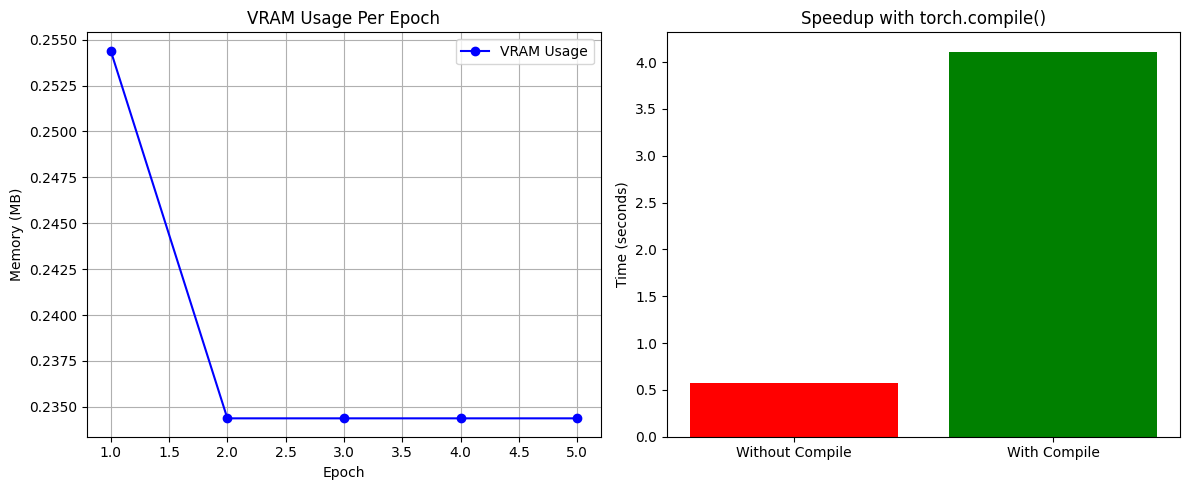

In [ ]:
def plot_results(memory_usage, epoch_times, speedup):
    epochs = range(1, len(memory_usage) + 1)

    # Plot VRAM Usage Over Epochs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, memory_usage, marker='o', linestyle='-', color='b', label="VRAM Usage")
    plt.xlabel("Epoch")
    plt.ylabel("Memory (MB)")
    plt.title("VRAM Usage Per Epoch")
    plt.legend()
    plt.grid()

    # Plot Speedup Comparison
    plt.subplot(1, 2, 2)
    plt.bar(["Without Compile", "With Compile"], speedup, color=["red", "green"])
    plt.ylabel("Time (seconds)")
    plt.title("Speedup with torch.compile()")

    plt.tight_layout()
    plt.show()

def main():
    # Hyperparameters
    input_dim, output_dim, rank = 128, 64, 8
    num_samples, batch_size, num_epochs = 1000, 32, 5
    learning_rate = 1e-3

    # Generate data
    x, y = generate_data(num_samples, input_dim, output_dim)
    dataset = TensorDataset(x, y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model and optimizer
   # Initialize model and optimizer
    model = QLoRAModel(input_dim, output_dim, rank).to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Measure speed without compilation
    start_time = time.time()
    memory_usage_no_compile, epoch_times_no_compile = train_model(model, dataloader, optimizer, num_epochs)
    time_no_compile = time.time() - start_time

    # ✅ Reinitialize optimizer for the compiled model
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Compile the model
    if hasattr(torch, 'compile'):
        logger.info("Compiling the model with torch.compile()...")
        model = torch.compile(model, mode='reduce-overhead')

    # Measure speed with compilation
    start_time = time.time()
    memory_usage_compile, epoch_times_compile = train_model(model, dataloader, optimizer, num_epochs)
    time_compile = time.time() - start_time

    # ... (rest of your code) ...

    # Compute speedup results
    speedup = [time_no_compile, time_compile]

    # Plot results
    plot_results(memory_usage_compile, epoch_times_compile, speedup)

if __name__ == "__main__":
    main()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import logging
import time

# Enable logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enable debug logging for graph breaks
torch._logging.set_logs(dynamo=logging.INFO, inductor=logging.INFO)

# Define a simple QLoRA model
class QLoRAModel(nn.Module):
    def __init__(self, input_dim, output_dim, rank):
        super(QLoRAModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

        # LoRA Parameters
        self.lora_A = nn.Parameter(torch.randn(input_dim, rank) * 0.01)
        self.lora_B = nn.Parameter(torch.randn(rank, output_dim) * 0.01)

    def forward(self, x):
        base_output = self.linear(x)
        lora_update = torch.matmul(x, self.lora_A)
        lora_update = torch.matmul(lora_update, self.lora_B)
        return base_output + lora_update

# Function to detect graph breaks
def check_graph_breaks(model, example_input):
    """
    Runs torch.compile() and checks for graph breaks.
    """
    logger.info("🔍 Checking for graph breaks...")

    # Get explanations for graph breaks
    compiled_model = torch.compile(model, mode='reduce-overhead')

    # Run a dummy forward pass
    try:
        with torch.no_grad():
            compiled_model(example_input)

        # Check the number of graph breaks
        num_graph_breaks = torch._dynamo.utils.counters["graph_break"]

        if num_graph_breaks > 0:
            logger.warning(f"🚨 GRAPH BREAK DETECTED! {num_graph_breaks} breaks occurred.")
            explanation = torch._dynamo.explain(model)(example_input)
            logger.info(f"🔍 Graph Break Explanation:\n{explanation}")
        else:
            logger.info("✅ No graph breaks detected! The model is fully compiled.")

    except Exception as e:
        logger.error(f"⚠️ Error during compilation: {str(e)}")

# Main function
def main():
    input_dim, output_dim, rank = 128, 64, 8
    model = QLoRAModel(input_dim, output_dim, rank).to(device)

    # Generate dummy data
    example_input = torch.randn(1, input_dim).to(device)

    # Check for graph breaks
    check_graph_breaks(model, example_input)

if __name__ == "__main__":
    main()


W0219 02:23:07.457000 798 torch/_logging/_internal.py:440] Using TORCH_LOGS environment variable for log settings, ignoring call to set_logs
V0219 02:23:07.467000 798 torch/_dynamo/convert_frame.py:930] [1/0] torchdynamo start compiling forward <ipython-input-57-053a79d3adfa>:28, stack (elided 5 frames):
V0219 02:23:07.467000 798 torch/_dynamo/convert_frame.py:930] [1/0]   File "<frozen runpy>", line 198, in _run_module_as_main
V0219 02:23:07.467000 798 torch/_dynamo/convert_frame.py:930] [1/0]   File "<frozen runpy>", line 88, in _run_code
V0219 02:23:07.467000 798 torch/_dynamo/convert_frame.py:930] [1/0]   File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
V0219 02:23:07.467000 798 torch/_dynamo/convert_frame.py:930] [1/0]     ColabKernelApp.launch_instance()
V0219 02:23:07.467000 798 torch/_dynamo/convert_frame.py:930] [1/0]   File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
V0219